Since we are moving toward a more build your own analyses approach, I figured this cross correlation analysis would be a good place to start. I will load modules as needed (as opposed to at the very beginning). 

# Part 1: Preparing Velocity Data

To start, we need to load and prepare the velocity data. Since it is in an ethovision format, we will borrow some of the code from `behavioral_analysis`. The code is wrapped up in an object to make it easier for Mike and Lucy, but we can still use a lot of the functionality. This part of the analysis will take place in four stages:

1. Load velocity data from the ethovision file
2. Get the ethovision offset
3. Get the fiber photometry offset
4. Shift the timing index of the velocity dataframe

### 1.1 Load velocity data

Ethovision files have a terrible structure with a bunch of header lines. Typically, we extract three components when we load ethovision data: the stimulus name, animal name, and the data itself. Since you just need the data, we will set `only_skip_lines=True`. The returned stimulus/animal names will be `None`

In [53]:
# Loading some plotting modules
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

In [59]:
import numpy as np
import pandas as pd
from behavioral_analysis.get_behavioral_events import GetBehavioralEvents

# put your datapaths below
ethovision_datapath = './data/Raw_data-Kevin_TTL_OFT-Trial_3.csv'

# Instantiate a GetBehavioralEvents object
etho_object = GetBehavioralEvents()

etho_data, _, _ = etho_object.load_ethovision_data(ethovision_datapath, only_skip_lines=True)

In [2]:
# Here are the first ten lines of the etho_data
etho_data.head(10)

,Trial time,Recording time,X center,Y center,X nose,Y nose,X tail,Y tail,Area,Areachange,Elongation,Direction,Velocity,Distance moved,Velocity 2,Result 1
0,2.035,0.000,19.1655,10.3634,18.4972,7.47779,21.3264,11.7406,17.0461,0.381986,0.294713,-101.638,-,-,-,1
1,2.068,0.033,19.1733,10.3743,18.5518,7.33493,21.2632,11.6791,17.6907,1.21758,0.369478,-102.584,0.401975,0.0134123,0.401975,1
2,2.102,0.066,19.1596,10.3464,18.5902,7.29958,21.2712,11.7166,17.7862,1.00271,0.377164,-102.431,0.933016,0.0311319,0.933016,1
3,2.135,0.100,19.1742,10.3318,18.6048,7.17243,21.2728,11.745,18.2876,1.02659,0.387202,-102.637,0.617931,0.0206185,0.617931,1
4,2.168,0.133,19.1561,10.3035,18.3921,7.24101,21.2946,11.7817,18.4069,0.692349,0.414364,-104.132,1.00712,0.0336036,1.00712,1
5,2.202,0.166,19.1374,10.3021,18.6027,7.15446,21.244,11.5485,17.3326,1.36082,0.396863,-102.675,0.562191,0.0187586,0.562191,1
6,2.235,0.200,19.1489,10.2821,18.5137,6.86396,21.2125,11.6547,18.4547,1.55182,0.403015,-100.385,0.691127,0.0230608,0.691127,1
7,2.268,0.233,19.1506,10.3024,18.3463,7.21144,21.2238,11.7156,17.7623,1.45632,0.342909,-100.631,0.610498,0.0203699,0.610498,1
8,2.302,0.266,19.1293,10.2773,18.4021,7.13099,21.1186,11.6098,18.3592,1.16983,0.409987,-99.8977,0.987676,0.0329558,0.987676,1
9,2.335,0.300,19.1249,10.2241,18.4378,6.99419,21.1903,11.6539,18.4547,1.24145,0.399544,-98.7693,1.59928,0.0533631,1.59928,1


### 1.2 Get the ethovision offset

For the offset, we need to load the offset datapath, and find where the start TTL occurs

In [3]:
offset_datapath = './data/Trial_control-Kevin_TTL_OFT-Trial_3.csv'

etho_offset_time = etho_object.get_ethovision_start_ttl(offset_datapath)

print('The ethovision offset time is: {} seconds'.format(etho_offset_time))

The ethovision offset time is: 2.035 seconds


### 1.3 Get the fiber photometry offset

For this section, we need to:

1. Load the data
2. Look at the events and event times
3. Extract the event label/time that seems appropriate

TDT data can have a complicated structure. It basically is:  
A block -> a list of segments  
A segment -> a list of analog signals and a list of events  
An event -> a list of times

So we need to extract a block, get the first segment, get out the list of events, and then look at the event names and start times to see which one looks good

In [19]:
from imaging_analysis.utils import ReadNeoTdt
fp_datapath = './data/FirstFibPho-190520-160005/'

block = ReadNeoTdt(fp_datapath)
segment = block.segments[0]
events = segment.events

event_list = []
for event in events:
    name = event.name
    first_event_time = event.times[0].magnitude
    print('Name: {}, First event time: {}'.format(name, first_event_time))
    event_list.append((name, first_event_time))

Name: PC0/, First event time: 40.0603554249
Name: Pu1/, First event time: 0.000492572784424
Name: PC0\, First event time: 640.046203852
Name: Pu1\, First event time: 0.500368356705


My guess is that 'PC0' is the appropriate channel. Since it was the first in the list, we pull it out

In [20]:
fp_offset = event_list[0][1]

print('The fiber photometry offset time is: {} seconds'.format(fp_offset))

The fiber photometry offset time is: 40.0603554249 seconds


### 1.4 Shift the velocity dataframe

We only need the 'Velocity' column and a time column. Since the ethovision offset time is 2.035 and this aligns with
the 'Recording time' column, we can just select that (for Lucy's data I had to calculate the offset manually). We will use the `fp_offset` variable in the next section

In [62]:
velocity_data = etho_data[['Recording time', 'Velocity']]
velocity_data.head(10)

,Recording time,Velocity
0,0.000,-
1,0.033,0.401975
2,0.066,0.933016
3,0.100,0.617931
4,0.133,1.00712
5,0.166,0.562191
6,0.200,0.691127
7,0.233,0.610498
8,0.266,0.987676
9,0.300,1.59928


You can see that there are some '-' in the velocity column, they need to be converted to `NaN`, and the rest need to be converted to numbers.

In [63]:
velocity_data.loc[velocity_data.Velocity == '-', 'Velocity'] = np.nan
velocity_data.loc[:, 'Velocity'] = velocity_data.loc[: 'Velocity'].astype(float)
velocity_data.head(10)

,Recording time,Velocity
0,0.000,NaN
1,0.033,0.401975
2,0.066,0.933016
3,0.100,0.617931
4,0.133,1.007120
5,0.166,0.562191
6,0.200,0.691127
7,0.233,0.610498
8,0.266,0.987676
9,0.300,1.599280


Here is the data plotted

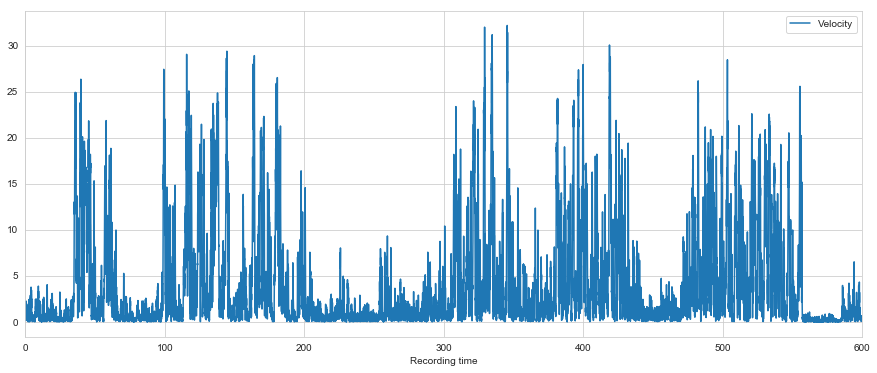

In [194]:
velocity_data.plot(x='Recording time', y='Velocity', figsize=(15, 6))

## Part 2: Preparing Imaging Data

We need to do a few steps for the imaging data:

1. Load the data, truncated to start at `fp_offset`
2. Filter
3. Detrend
4. Calculate $\Delta$f/f
5. Organize the data into a nice dataframe

### 2.1 Load the data

Since we have an offset (around 40 seconds), we can truncate all the imaging data before that point.

Similar to processing events above, we need to get the reference and signal channel names so we can extract the correct analog signals. Since we loaded the `segment` earlier, we can just extract the analog signals from there:

In [196]:
analogsignals = segment.analogsignals
analogsignals

[AnalogSignal with 1 channels of length 664192; units V; datatype float32 
 name: '405A 1'
 annotations: {'channel_index': 1}
 sampling rate: 1017.25262451
 time: 9.53674316406e-07 to 652.927291575,
 AnalogSignal with 1 channels of length 664192; units V; datatype float32 
 name: '465A 1'
 annotations: {'channel_index': 1}
 sampling rate: 1017.25262451
 time: 9.53674316406e-07 to 652.927291575,
 AnalogSignal with 1 channels of length 3985408; units V; datatype float32 
 name: 'Fi1r 1'
 annotations: {'channel_index': 1}
 sampling rate: 6103.515625
 time: 9.53674316406e-07 to 652.969247674,
 AnalogSignal with 1 channels of length 3985408; units V; datatype float32 
 name: 'Fi1r 2'
 annotations: {'channel_index': 2}
 sampling rate: 6103.515625
 time: 9.53674316406e-07 to 652.969247674,
 AnalogSignal with 1 channels of length 3985408; units V; datatype float32 
 name: 'Fi1r 3'
 annotations: {'channel_index': 3}
 sampling rate: 6103.515625
 time: 9.53674316406e-07 to 652.969247674]

So the first channel is our baseline and the second is our signal. We also need the sampling rate and the clock. In an `analogsignal` object, we can get the raw numbers by calling `.magnitude` and the sampling rate by `.sampling_rate`. We also need to get the clock, so we use `.times`.

Remember that in python, indexing starts at 0.

In [197]:
sampling_rate = analogsignals[0].sampling_rate.magnitude

reference = analogsignals[0]
signal = analogsignals[1]

We can truncate the analog signal object using `TruncateSignal`, then we will extract the raw signal itself using `.magnitude`

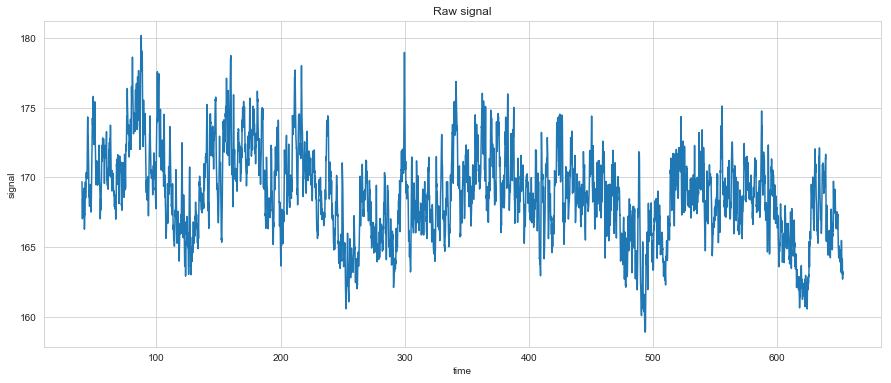

In [198]:
from imaging_analysis.signal_processing import TruncateSignal
reference = TruncateSignal(reference, start=fp_offset)
signal = TruncateSignal(signal, start=fp_offset)
clock = signal.times.magnitude

reference = reference.magnitude
signal = signal.magnitude

plt.figure(figsize=(15,6))
plt.plot(clock, signal)
plt.title('Raw signal')
plt.xlabel('time');
plt.ylabel('signal');

## 2.2 Filter the data

We pass the signals through a low pass filter, cutting off anything above 40 Hz

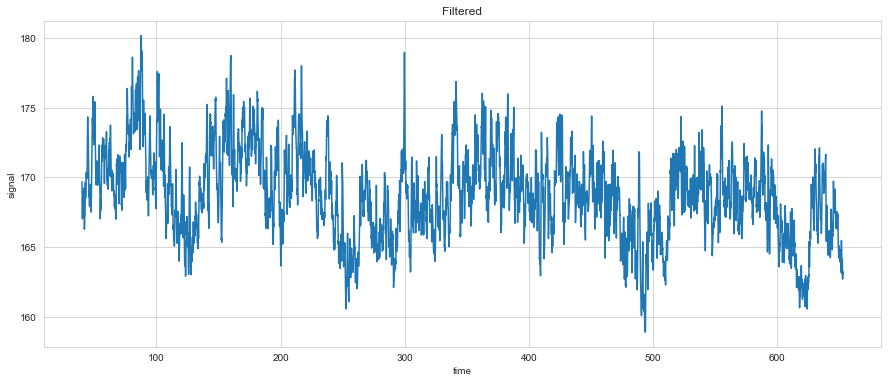

In [199]:
from imaging_analysis.signal_processing import FilterSignal
filtered_signal = FilterSignal(signal, highcut=40, btype='lowpass')
filtered_reference = FilterSignal(reference, highcut=40, btype='lowpass')

plt.figure(figsize=(15,6))
plt.plot(clock, filtered_signal)
plt.title('Filtered')
plt.xlabel('time');
plt.ylabel('signal');

## 2.3 Detrend the data

I'm not sure how you want to detrend, so I just chose a standard savgol detrending option

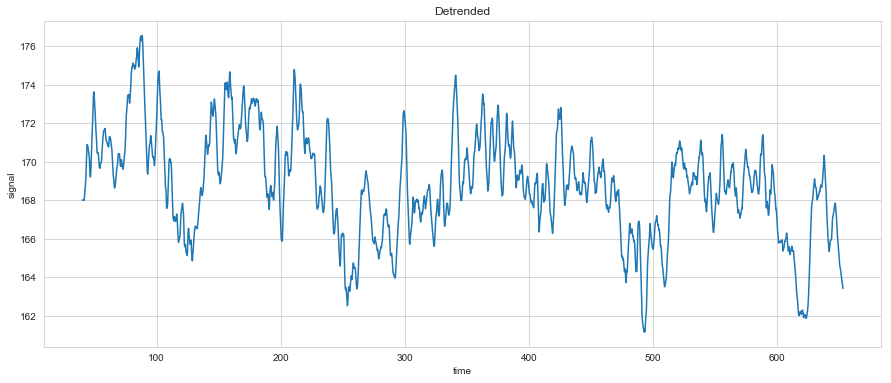

In [200]:
detrended_signal = FilterSignal(filtered_signal, btype='savgol')
detrended_reference = FilterSignal(filtered_reference, btype='savgol')

plt.figure(figsize=(15,6))
plt.plot(clock, detrended_signal)
plt.title('Detrended')
plt.xlabel('time');
plt.ylabel('signal');

## 2.4 Calculate $\Delta$f/f

We will calculate $\Delta$f/f by using median subtraction

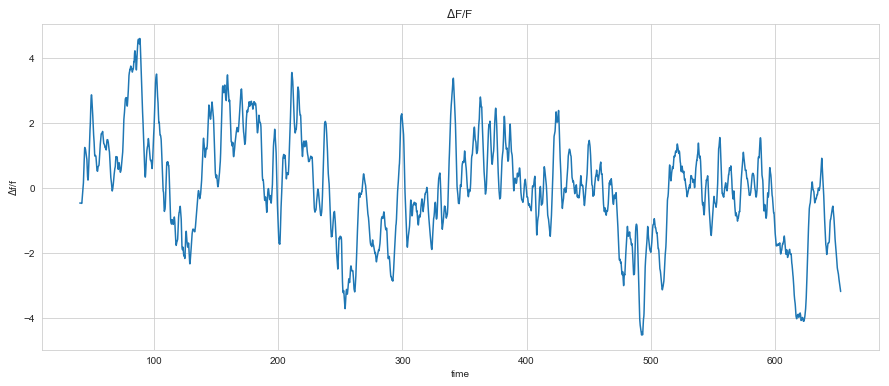

In [201]:
from imaging_analysis.signal_processing import DeltaFOverF

deltaf = DeltaFOverF(detrended_signal, detrended_reference, mode='median')

plt.figure(figsize=(15,6))
plt.plot(clock, deltaf)
plt.title('$\Delta$F/F')
plt.xlabel('time');
plt.ylabel('$\Delta$f/f');

## 2.5 Put it together into a nice dataframe

In [285]:
#data_dictionary = {'Recording time': clock.flatten(), 'Signal': signal.flatten()}
data_dictionary = {'Recording time': clock.flatten(), 'Signal': deltaf.flatten()}


imaging_data = pd.DataFrame(data_dictionary)
imaging_data.head()

,Recording time,Signal
0,40.060846,-0.463937
1,40.061829,-0.463937
2,40.062812,-0.463938
3,40.063795,-0.463939
4,40.064778,-0.463940


We can subtract the first 'Recording time' value so that we start at 0

In [286]:
imaging_data.loc[:, 'Recording time'] = imaging_data.loc[:, 'Recording time'] - imaging_data.loc[0, 'Recording time']
imaging_data.head(10)

,Recording time,Signal
0,0.000000,-0.463937
1,0.000983,-0.463937
2,0.001966,-0.463938
3,0.002949,-0.463939
4,0.003932,-0.463940
5,0.004915,-0.463941
6,0.005898,-0.463941
7,0.006881,-0.463942
8,0.007864,-0.463943
9,0.008847,-0.463944


## Part 3: Downsampling and having matching lengths

The imaging and velocity data are captured at different frequences, so we need to resample them. The signals might not be perfectly aligned, so I will make an assumption that 'Recording times' that are super close would result in the same value.

To achieve this we do it in two steps:
1. An outer join of the imaging and velocity dataframes, where we do forward and back filling (upsampling the velocity data)
2. Only keep the rows that correspond to the original velocty dataframe

Doing it this way makes sure that there is no slight shift over time and can handle weird ratios of sampling rates.

In [287]:
velocity_sampling_rate = 1. / velocity_data['Recording time'].diff().iloc[1]
combined_data = pd.merge(imaging_data, velocity_data, on='Recording time', how='outer', sort=True).ffill().bfill()
combined_data.head(10)

,Recording time,Signal,Velocity
0,0.000000,-0.463937,0.401975
1,0.000983,-0.463937,0.401975
2,0.001966,-0.463938,0.401975
3,0.002949,-0.463939,0.401975
4,0.003932,-0.463940,0.401975
5,0.004915,-0.463941,0.401975
6,0.005898,-0.463941,0.401975
7,0.006881,-0.463942,0.401975
8,0.007864,-0.463943,0.401975
9,0.008847,-0.463944,0.401975


In [288]:
final_dataset = combined_data.loc[combined_data['Recording time'].isin(velocity_data['Recording time'].unique()), :].copy()
final_dataset.set_index('Recording time', inplace=True)
final_dataset.head(10)

,Signal,Velocity
Recording time,,
0.000,-0.463937,0.401975
0.033,-0.463962,0.401975
0.066,-0.463988,0.933016
0.100,-0.464014,0.617931
0.133,-0.464040,1.007120
0.166,-0.464066,0.562191
0.200,-0.464093,0.691127
0.233,-0.464119,0.610498
0.266,-0.464144,0.987676


## Part 5: Coherence and Cross-correlations

There are two ways that time-series can be similar, by their time domain (cross-corelation) and by their frequency domain (coherence). We will look at the latter first.

**Note**: you can also look at [wavelet coherence](https://hal.archives-ouvertes.fr/hal-00302394/document), which is a method to look at both time and frequency at the same-time. I think it's overkill for your needs and there are not a lot of resources for it.

### 5.1 Coherence
Coherence is always between 0 and 1 and measures the power transfer between two series. Where cross-correlation looks at the correlation/autocorrelation of time-series, coherence looks at the cross-spectral/autospectral density. If two time-series have high coherence (and are ergodic and part of a linear system), then you might be able to infer that one causes the other.

Most of this research is in the atmospheric/geological sciences, and there is an old [paper](https://journals.ametsoc.org/doi/pdf/10.1175/1520-0469%281979%29036%3C2020%3ACSL%3E2.0.CO%3B2) for statistical cutoffs that I found. You would need a great sample size, but note that for an `N=3`, a significant coherence is **0.881**, which is super high.

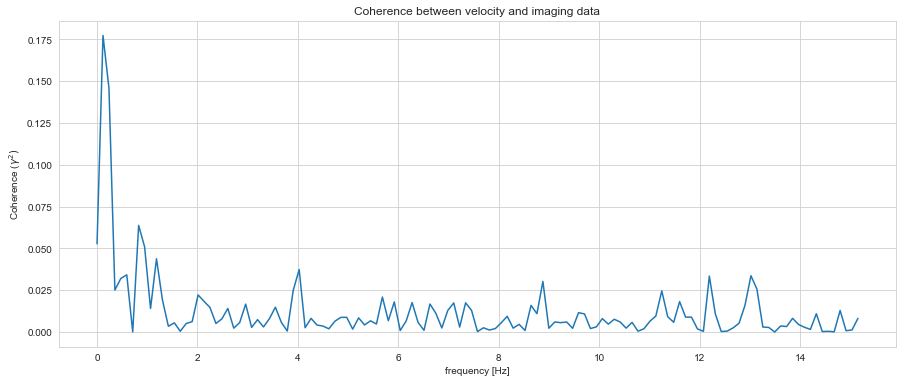

In [289]:
from scipy.signal import coherence
f, Cxy = coherence(final_dataset.Velocity.values, final_dataset.Signal.values, fs=velocity_sampling_rate)

plt.figure(figsize=(15,6))
plt.plot(f, Cxy)
plt.title('Coherence between velocity and imaging data')
plt.xlabel('frequency [Hz]')
plt.ylabel('Coherence ($\gamma^2)$')
plt.show()

The coherence values are really low, so there is a almost no chance that the time-series are related from a frequency perspective.  

In fact, the real coherence is probably even lower. This method assumes stationarity. Normally, we should try and transform our time-series to be stationary like ([whitening transformation](https://en.wikipedia.org/wiki/Whitening_transformation)). For both coherence and cross-correlation, you have a tendency towards finding spurious relationships. Here is a neuroscience [paper](https://link.springer.com/content/pdf/10.3758%2Fs13428-015-0611-2.pdf) that goes into detail about what to do instead.

If you eventually do find significant coherence/cross-correlation, we should expand the analysis to be a bit more careful, but as of right now, this should do.

## 5.2 Cross-correlation

I've defined a normalized cross correlation function. While you can do this stuff here, `R` has some really nice statistical analyses with auto/cross correlations.

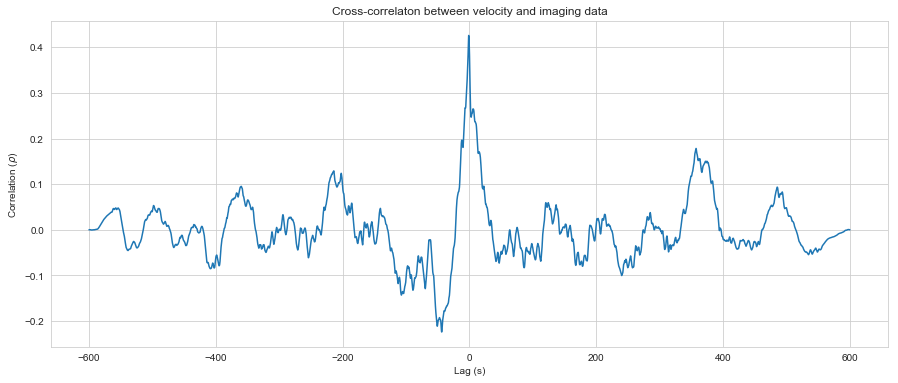

In [317]:
from scipy.signal import correlate

a = final_dataset.Velocity.values
b = final_dataset.Signal.values

def Normalized_cross_correlation(a, b):
    a = (a - np.mean(a)) / (np.std(a) * len(a))
    b = (b - np.mean(b)) / (np.std(b))
    c = np.correlate(a, b, 'full')
    return c

c = Normalized_cross_correlation(a, b)
lag = np.concatenate((-1*final_dataset.index[::-1], final_dataset.index[1:]))


plt.figure(figsize=(15,6))
plt.plot(lag, c)
plt.title('Cross-correlaton between velocity and imaging data')
plt.xlabel('Lag (s)')
plt.ylabel('Correlation ($\\rho$)')
plt.show()

In [319]:
velocity_auto_corr = Normalized_cross_correlation(a, a)
fp_auto_corr = Normalized_cross_correlation(b, b)

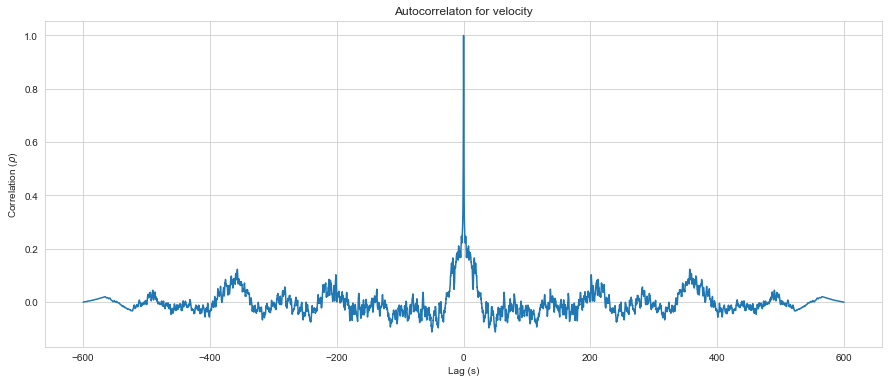

In [320]:
plt.figure(figsize=(15,6))
plt.plot(lag, velocity_auto_corr)
plt.title('Autocorrelaton for velocity')
plt.xlabel('Lag (s)')
plt.ylabel('Correlation ($\\rho$)')
plt.show()

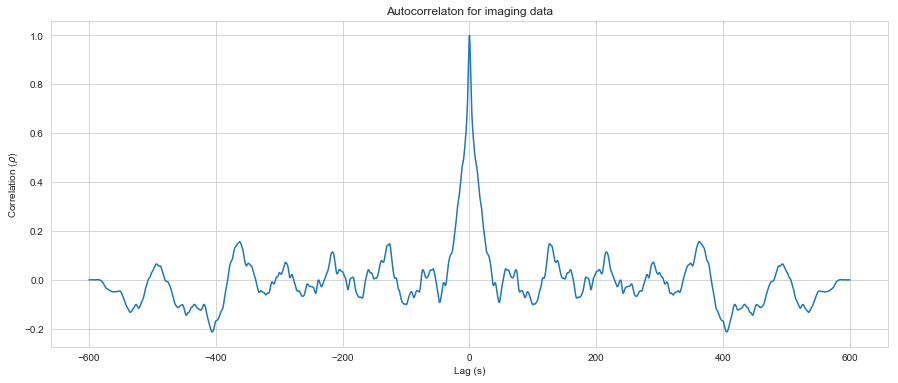

In [321]:
plt.figure(figsize=(15,6))
plt.plot(lag, fp_auto_corr)
plt.title('Autocorrelaton for imaging data')
plt.xlabel('Lag (s)')
plt.ylabel('Correlation ($\\rho$)')
plt.show()

They both have a lot of autocorreation - especially the imaging data. This means that we cannot use cross-correlation without a lot of preprocessing (whitening, etc.)

It might actually be best to think of a more comprehensive method. I think you should take a look at that neuroscience [paper](https://link.springer.com/content/pdf/10.3758%2Fs13428-015-0611-2.pdf) and we can discuss.

**Also please note that there could be errors in my code. Please check the coherence and correlation code carefully.**